## The Clustering Scenario: Metabolic Syndromes

We will use K-Means Clustering to group patients based on a "Health Fingerprint" consisting of:

- **Physicality**: BMI and Waist Circumference.
- **Dietary Habits**: Total Calories, Sodium, and Sugar intake.
- **Lipid Profile**: Total Cholesterol.

The goal is to identify distinct "Health Phenotypes" (e.g., "The Sodium-Heavy Profile," "The High-Sugar Sedentary Profile," or "The Balanced High-Risk Profile") to help clinicians tailor lifestyle interventions.

## Import Required Libraries

Import the necessary libraries for clustering analysis, data preprocessing, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## MetabolicClusteringSystem Class

Define a comprehensive system for unsupervised learning to identify patient phenotypes based on body metrics, diet, and lab results.

In [2]:
class MetabolicClusteringSystem:
    """
    An unsupervised learning system to identify patient 'phenotypes' 
    based on the intersection of body metrics, diet, and lab results.
    """

    def __init__(self, n_clusters=4):
        self.n_clusters = n_clusters
        # Features that define a lifestyle/metabolic profile
        self.features = [
            'BMXBMI', 'BMXWAIST',       # Physicality
            'DR1TKCAL', 'DR1TSODI', 'DR1TSUGR', # Diet (Calories, Sodium, Sugar)
            'LBXTC'                     # Labs (Cholesterol)
        ]
        
        # We keep the imputer and scaler for consistent data processing
        self.imputer = SimpleImputer(strategy='median')
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.pca = PCA(n_components=2) # For visualization
        self.is_fitted = False

    def load_and_sync_data(self):
        """Merges disparate data sources into a single metabolic profile."""
        print("--- PHASE 1: Data Integration ---")
        exam = pd.read_csv('med_data/examination.csv')[['SEQN', 'BMXBMI', 'BMXWAIST']]
        diet = pd.read_csv('med_data/diet.csv')[['SEQN', 'DR1TKCAL', 'DR1TSODI', 'DR1TSUGR']]
        labs = pd.read_csv('med_data/labs.csv')[['SEQN', 'LBXTC']]
        
        # Merge all on Sequence Number
        df = exam.merge(diet, on='SEQN').merge(labs, on='SEQN')
        return df

    def fit_clusters(self, df):
        """
        LOGICAL THINKING:
        Clustering identifies patterns we didn't explicitly ask for.
        By scaling the data, we ensure 'Sodium' (measured in mg) doesn't 
        outweigh 'BMI' (measured in units) just because the numbers are larger.
        """
        print(f"--- PHASE 2: Clustering {len(df)} patients into {self.n_clusters} Phenotypes ---")
        
        # Extract features and handle missing data
        X = df[self.features]
        X_imputed = self.imputer.fit_transform(X)
        X_scaled = self.scaler.fit_transform(X_imputed)
        
        # Perform K-Means Clustering
        self.kmeans.fit(X_scaled)
        df['cluster'] = self.kmeans.labels_
        
        # Reduce dimensions for visualization purposes
        self.pca_coords = self.pca.fit_transform(X_scaled)
        df['pca_1'] = self.pca_coords[:, 0]
        df['pca_2'] = self.pca_coords[:, 1]
        
        self.is_fitted = True
        return df

    def get_cluster_profiles(self, df):
        """Analyzes the clusters to provide human-readable clinical summaries."""
        summary = df.groupby('cluster')[self.features].mean()
        
        # Calculate cluster sizes
        counts = df['cluster'].value_counts().sort_index()
        summary['patient_count'] = counts
        
        return summary

    def get_patient_phenotype(self, patient_data):
        """
        EHR INFERENCE:
        Assigns a new patient to an existing cluster to guide clinical focus.
        """
        if not self.is_fitted: return "System not initialized."
        
        # Prepare input
        input_df = pd.DataFrame([patient_data])[self.features]
        input_imputed = self.imputer.transform(input_df)
        input_scaled = self.scaler.transform(input_imputed)
        
        cluster_id = self.kmeans.predict(input_scaled)[0]
        
        # Clinical logic based on cluster characteristics (generalized)
        profiles = {
            0: "Balanced Profile: Moderate metrics across all categories.",
            1: "High Caloric/Sugar Profile: Focus on glycemic control and weight management.",
            2: "High Sodium/Cholesterol Profile: Focus on cardiovascular health and blood pressure.",
            3: "Elevated Body Metric Profile: Significant risk for metabolic syndrome; focus on lifestyle."
        }
        
        return {
            "assigned_cluster": int(cluster_id),
            "phenotype_summary": profiles.get(cluster_id, "Unknown Profile"),
            "action_plan": "Discuss lifestyle cluster with patient to tailor intervention."
        }

## Execute Clustering Analysis

Initialize the system, load and integrate data from multiple sources, and perform K-Means clustering to identify patient phenotypes.

In [3]:
system = MetabolicClusteringSystem(n_clusters=4)
data = system.load_and_sync_data()
clustered_data = system.fit_clusters(data)

--- PHASE 1: Data Integration ---
--- PHASE 2: Clustering 9813 patients into 4 Phenotypes ---


## Visualize Clusters with PCA

Plot the clusters in 2D space using Principal Component Analysis to visually inspect cluster separation and patient distribution.

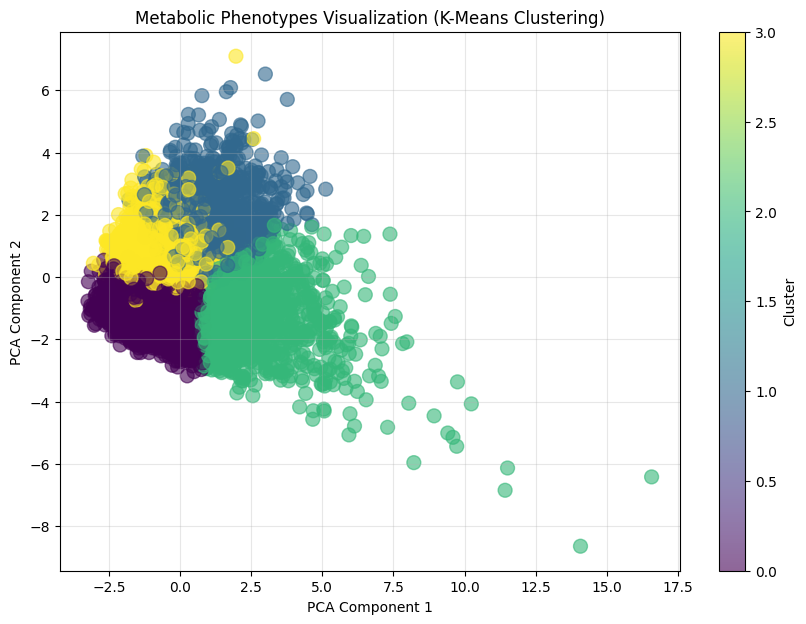

In [4]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(clustered_data['pca_1'], clustered_data['pca_2'], 
                     c=clustered_data['cluster'], cmap='viridis', alpha=0.6, s=100)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Metabolic Phenotypes Visualization (K-Means Clustering)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

## Generate Cluster Profiles

Calculate mean values of all features grouped by cluster to understand phenotype characteristics and actionable clinical insights.

In [5]:
# Generate and show cluster profiles
profiles = system.get_cluster_profiles(clustered_data)
print("\n--- METABOLIC CLUSTER PROFILES (Averages) ---")
print(profiles)


--- METABOLIC CLUSTER PROFILES (Averages) ---
            BMXBMI    BMXWAIST     DR1TKCAL     DR1TSODI    DR1TSUGR  \
cluster                                                                
0        18.852655   65.715518  1711.806204  2733.939781  100.444088   
1        37.287301  116.989611  1985.496291  3348.565071  101.185610   
2        25.979682   90.959396  3515.259657  5721.764664  204.584199   
3        26.880718   93.860985  1446.840550  2287.520962   76.005859   

              LBXTC  patient_count  
cluster                             
0        151.918707           3343  
1        175.664083           1632  
2        178.507680           1398  
3        205.258337           3440  


## Patient Phenotype Assignment

Demonstrate how to assign a new patient to an existing cluster and generate actionable clinical recommendations based on their phenotype.

In [6]:
# EHR Simulation: Classify a random patient into a phenotype
sample_patient = data.iloc[100].to_dict()
print("\n--- EHR PHENOTYPING INFERENCE ---")
phenotype_result = system.get_patient_phenotype(sample_patient)
print(f"Assigned Cluster: {phenotype_result['assigned_cluster']}")
print(f"Phenotype Summary: {phenotype_result['phenotype_summary']}")
print(f"Action Plan: {phenotype_result['action_plan']}")


--- EHR PHENOTYPING INFERENCE ---
Assigned Cluster: 3
Phenotype Summary: Elevated Body Metric Profile: Significant risk for metabolic syndrome; focus on lifestyle.
Action Plan: Discuss lifestyle cluster with patient to tailor intervention.


## Clinical Interpretation and Insights

### Why Clustering is the "Hidden Gem" for your EHR app:

**Discovery vs. Detection**: Regression and Classification detect what we tell them to look for (like SBP). Clustering discovers what is actually there. It might find a cluster of young, low-BMI patients who have dangerously high cholesterol—a group that might be missed by standard screening rules.

**Tailored Patient Education**: Instead of telling every patient to "eat better," a doctor can use the clustering results to be specific: "Our data shows you are in the 'Sodium-Heavy' group. For your specific body type, sodium is the primary driver of your health risk."

**Population Health Management**: For a clinic manager, this code shows how many patients fall into "High Risk" clusters. If Cluster 1 (High Sugar) is growing, the clinic might decide to hire a nutritionist or launch a diabetes prevention program.

**Dimensionality Reduction**: The PCA logic enables you to plot thousands of patients on a simple 2D map, making it easy for clinicians to visualize where a specific patient sits relative to the rest of the clinic's population.

### Completing Your ML Suite for the NHANES Dataset:

- **Regression**: How high is the risk (SBP, HbA1c)?
- **Classification**: Is there a specific disease (Kidney Risk)?
- **Clustering**: What kind of patient are they (Metabolic Phenotype)?